In [1]:
import pennylane as qml
from pennylane import numpy as np
import numpy as npp
import matplotlib.pyplot as plt

In [2]:
n_wires=5
dev = qml.device("default.qubit", wires=n_wires)
filename='Saved_Data/starting_point_1.npy'
sample_t = np.linspace(0.1, 0.9, 10, endpoint=False)
print(sample_t)

[0.1  0.18 0.26 0.34 0.42 0.5  0.58 0.66 0.74 0.82]


In [3]:
def u(t):
    return npp.sin(t)
    # return t


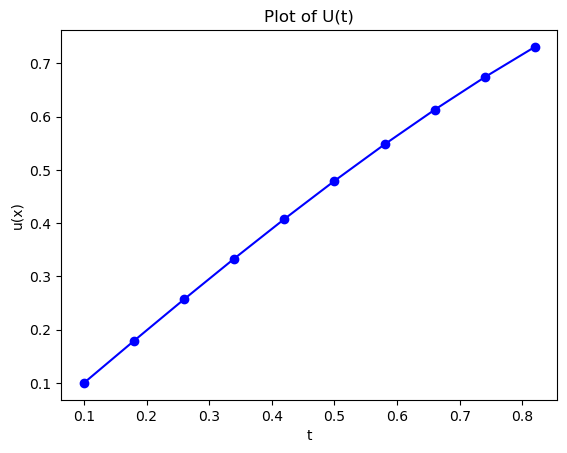

In [4]:
def plot_u(t,u):
    sample_u = u(t)
    plt.plot(t, sample_u, 'bo-', label='Actual')
    plt.xlabel('t')
    plt.ylabel('u(x)')
    plt.title('Plot of U(t)')
    # plt.grid(True)
    plt.show()
    
plot_u(sample_t,u)

In [5]:
def phi(t, j):  # Chebyshev
    return 2 * j * np.arccos(t)

def dphi1(t):
    return -1 / np.sqrt(1 - t ** 2)

def dphi2(t):
    return -t / ((1 - t ** 2) ** (3 / 2))

In [6]:

@qml.qnode(dev, diff_method="backprop", interface="autograd")
def circuit(params,t):
    for j in range(1,n_wires+1):
        qml.RY(phi=phi(t,j+1),wires=j-1)
    qml.StronglyEntanglingLayers(weights=params, wires=[i for i in range(n_wires)])
    # return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3))
    return qml.expval(qml.PauliZ(0))

# initialize circuit parameters
param_shape = qml.StronglyEntanglingLayers.shape(n_wires=n_wires, n_layers=1)
params = np.random.normal(scale=0.1, size=param_shape, requires_grad=True)
print(params)
# params_1d = params.flatten()
# print(params_1d)
# params_restored = params_1d.reshape(param_shape)
# print(params_1d)
# print(params_restored)
print(qml.draw(circuit)(params,1))
print(qml.grad(circuit,argnum=0)(params,1))

[[[-0.06716655  0.00701095  0.04914832]
  [-0.09220649  0.04286228  0.23059409]
  [-0.02633414 -0.18264507 -0.03897307]
  [-0.19189682  0.06925635 -0.04597078]
  [ 0.15216837  0.09703486  0.0490417 ]]]
0: ──RY(0.00)─╭StronglyEntanglingLayers(M0)─┤  <Z>
1: ──RY(0.00)─├StronglyEntanglingLayers(M0)─┤     
2: ──RY(0.00)─├StronglyEntanglingLayers(M0)─┤     
3: ──RY(0.00)─├StronglyEntanglingLayers(M0)─┤     
4: ──RY(0.00)─╰StronglyEntanglingLayers(M0)─┤     
[[[-1.73467054e-17 -8.67361738e-19 -1.73477642e-17]
  [-2.77962332e-17 -4.18376785e-02 -2.77149180e-17]
  [-3.45928256e-17  1.80177845e-01 -3.47961135e-17]
  [-1.35525272e-20 -6.76676369e-02  1.35525272e-20]
  [ 1.37964726e-17 -9.49554950e-02  1.39591030e-17]]]


In [7]:
#train with u_t
def loss_exact(params):
    u_pred = []
    loss = 0
    for i in range(len(sample_t)):
        # loss += (circuit(params,t)-u(t))**2 
        u_pred.append(circuit(params,sample_t[i]))
    loss = np.mean((np.array(u_pred) - u(sample_t))**2)
    return loss        

In [8]:
def plot_u_predict(params):
    sample_u = np.zeros(len(sample_t))
    for i in range(len(sample_t)):
        sample_u[i] = circuit(params,sample_t[i])

    plt.plot(sample_t, sample_u, 'r*-', label='Predicted')
    plt.xlabel('t')
    plt.ylabel('u_predict(x)')
    plt.title('Plot of U_predict(t)')
    plt.legend()
    plt.grid(True)
    # plt.grid(True)
    # plt.show()

Step  0 
 params =  None  loss =  0.21139359123463106


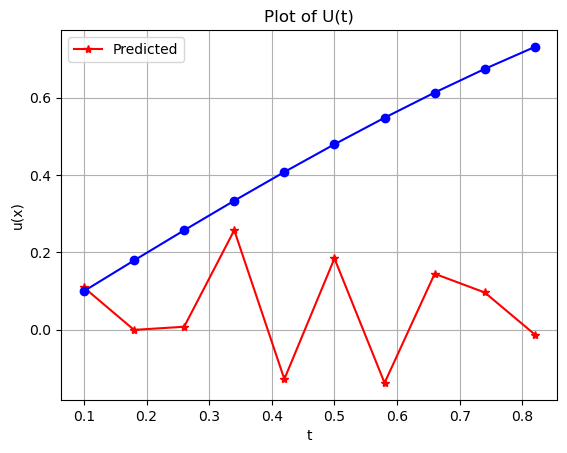

Step  25 
 params =  None  loss =  0.12544542430750777


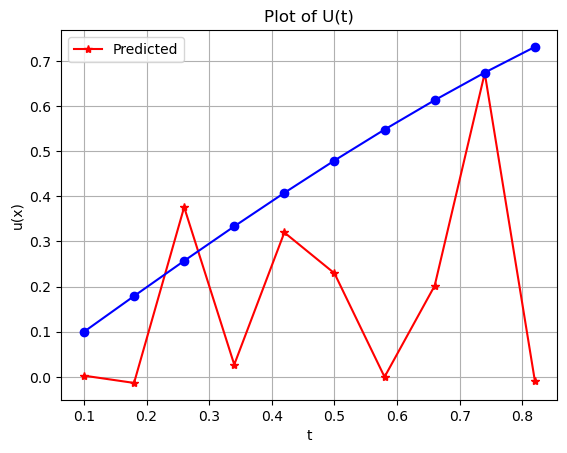

Step  50 
 params =  None  loss =  0.12007369006929025


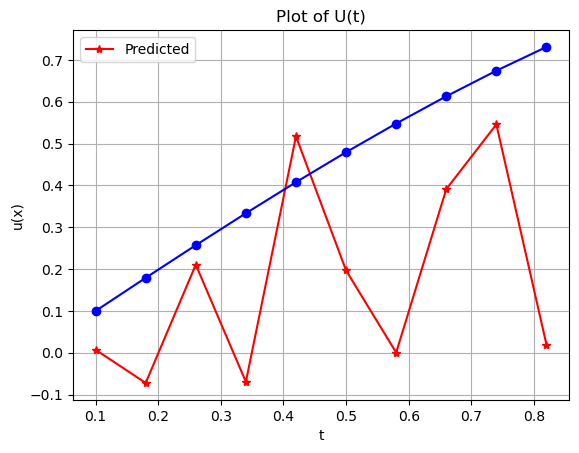

Step  75 
 params =  None  loss =  0.119503739343551


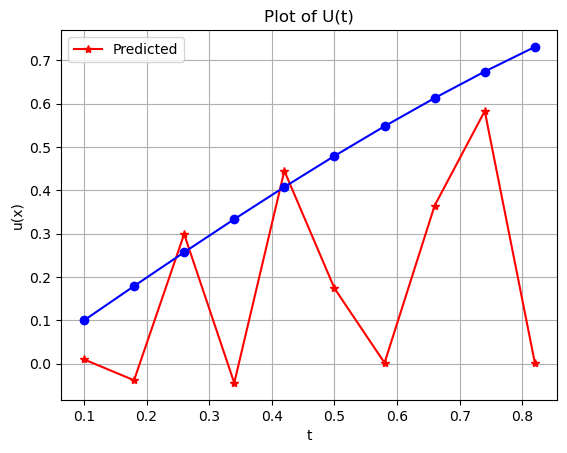

Step  100 
 params =  None  loss =  0.11946054669921935


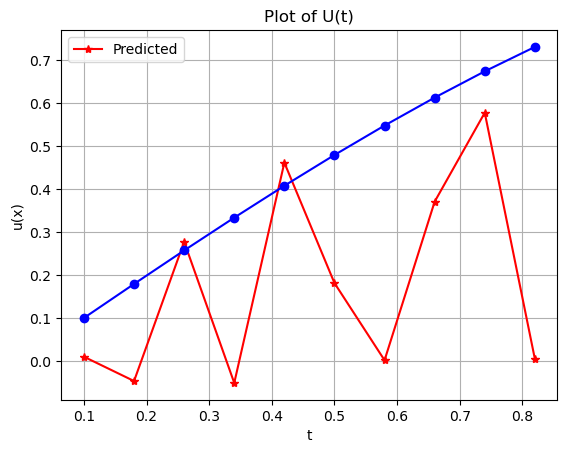

Step  125 
 params =  None  loss =  0.11945780358874751


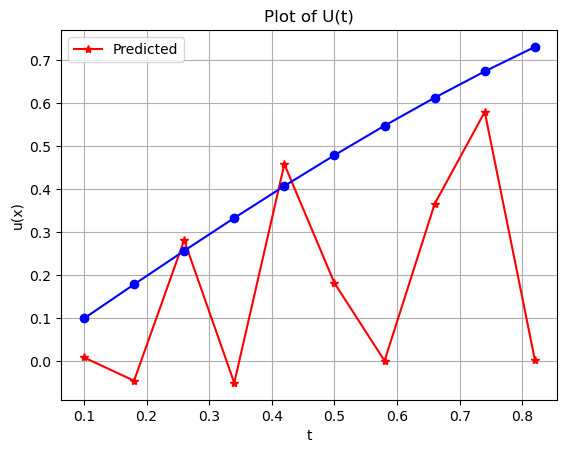

Step  150 
 params =  None  loss =  0.11945761998508364


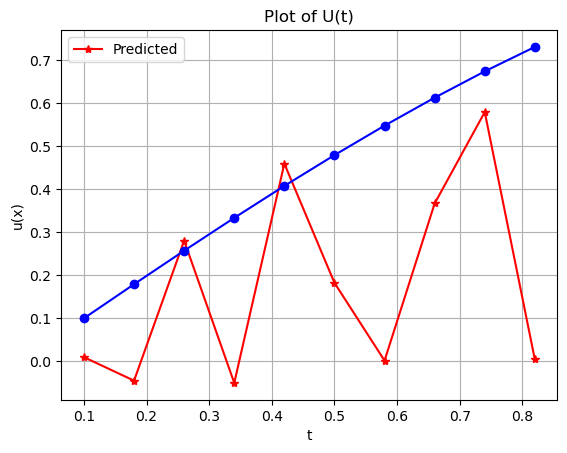

Step  175 
 params =  None  loss =  0.11945759818808162


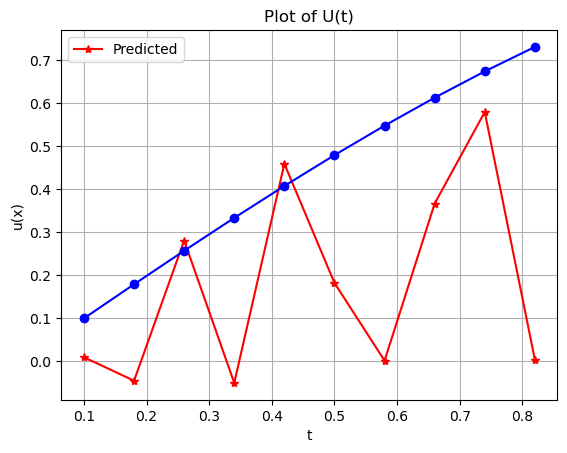

Step  200 
 params =  None  loss =  0.11945759638680742


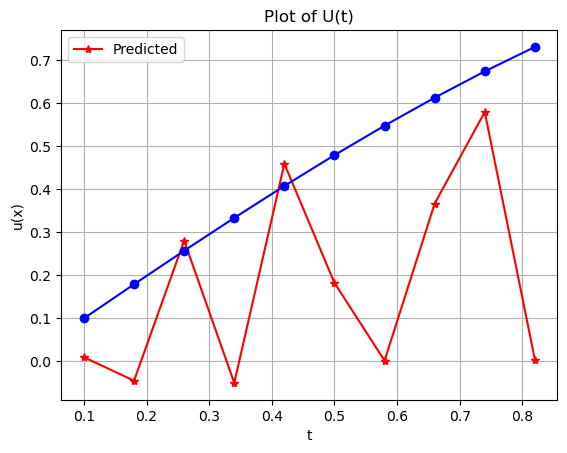

Step  225 
 params =  None  loss =  0.11945759630943023


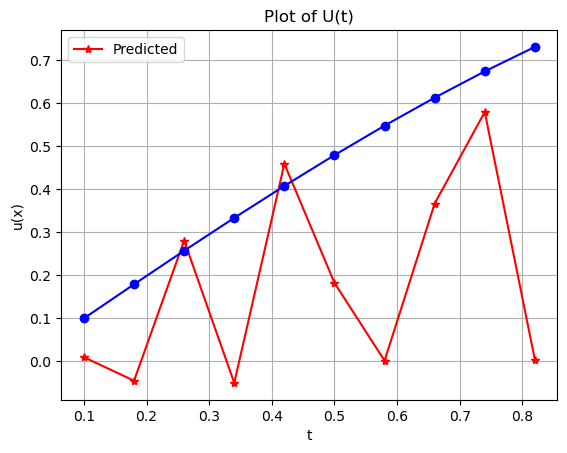

Step  250 
 params =  None  loss =  0.11945759630799788


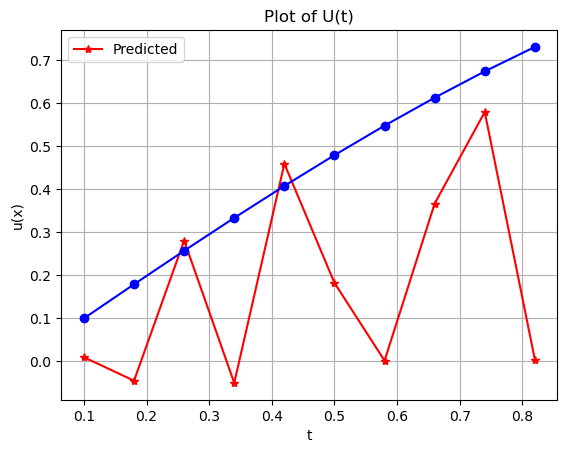

Step  275 
 params =  None  loss =  0.11945759630749922


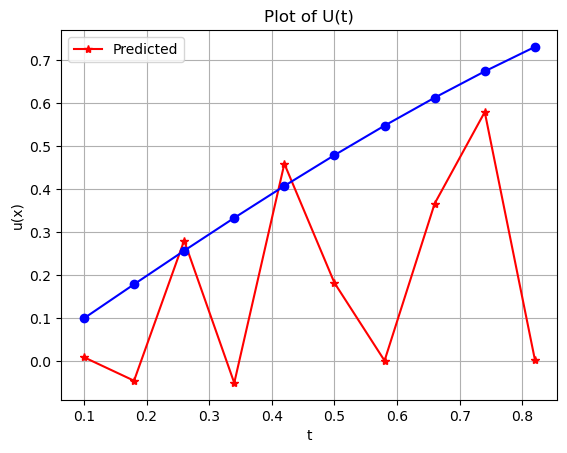

In [9]:
opt = qml.AdamOptimizer(0.05, beta1=0.9, beta2=0.999)

for i in range(300):
    params, loss = opt.step_and_cost(loss_exact, params)
    if i%25==0:
        print("Step ", i, "\n params = ", None,' loss = ',loss)
        plot_u_predict(params)
        plot_u(sample_t,u)
        # np.save(filename, params)

In [10]:
# q_u_prime = np.zeros(len(sample_t))
# for i in range(len(q_u_prime)):
#     for j in range(n_wires):
